<a href="https://colab.research.google.com/github/aloktripathy2698/Boston-Crime-Analysis/blob/main/Boston_Crime_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import pandas as pd
import sqlite3
from sqlite3 import Error
from pprint import pprint
from datetime import datetime
import glob
import os
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure, show

# Fetching Data from Github

In [2]:
!git clone https://github.com/aloktripathy2698/Boston-Crime-Analysis.git

Cloning into 'Boston-Crime-Analysis'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 21 (delta 9), reused 10 (delta 3), pack-reused 0
Unpacking objects: 100% (21/21), done.


# Defining Helper Functions

In [4]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows


# Creating database.

In [5]:
#Creating Table for loading the data from multiple CSV.

db_filename = "boston_crime.db"
conn = create_connection(db_file=db_filename, delete_db=False)
create_sql_query = """
    CREATE TABLE ORIGINAL(
      [INCIDENT_NUMBER] TEXT NOT NULL PRIMARY KEY,
      [OFFENSE_CODE] INTEGER,
      [OFFENSE_CODE_GROUP] TEXT,
      [OFFENSE_DESCRIPTION] TEXT,
      [DISTRICT] TEXT,
      [REPORTING_AREA] REAL,
      [SHOOTING] TEXT,
      [OCCURRED_ON_DATE] DATETIME,
      [YEAR] INTEGER,
      [MONTH] INTEGER,
      [DAY_OF_WEEK] TEXT,
      [HOUR] INTEGER,
      [UCR_PART] TEXT,
      [STREET] TEXT,
      [Lat] REAL,
      [Long] REAL,
      [Location] TEXT
    );
    """
create_table(conn, create_sql_query, drop_table_name="ORIGINAL")
conn.close()

## Inserting raw data from multiple csv.

In [6]:
#Bulk Inserting data into the table
import csv

path = '/content/Boston-Crime-Analysis' 
all_files = glob.glob(os.path.join(path, "*.csv"))

conn = create_connection(db_file= db_filename, delete_db=False)
cur = conn.cursor()

insert_sql_query = """INSERT INTO ORIGINAL (INCIDENT_NUMBER, OFFENSE_CODE, OFFENSE_CODE_GROUP, OFFENSE_DESCRIPTION,	DISTRICT,	REPORTING_AREA,	
          SHOOTING, OCCURRED_ON_DATE,	YEAR, MONTH,	DAY_OF_WEEK,	HOUR,	UCR_PART,	STREET,	Lat,	Long, Location) 
          VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);"""

for filename in all_files:
  with open(filename) as file:
      line = csv.reader(file)
      i = 1
      data = []
      for row in line:
        row = [x if x.strip() != "" else None for x in row]
        if row[13] is not None:
          row[13] = row[13].splitlines()[0]
        #print(row[13])
        if i > 1:
          data.append(tuple(row))
        i += 1

  cur.executemany(insert_sql_query, data)
  conn.commit()


In [8]:
sql_statement = "SELECT * FROM ORIGINAL;"
raw_data = pd.read_sql_query(sql_statement, conn)
raw_data.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,S87066666,3301,None,VERBAL DISPUTE,B2,300.0,0,4/7/2022 19:30,2022,4,Thursday,19,None,THORNTON PLACE,0.000000,0.000000,"(0, 0)"
1,225520077,3115,None,INVESTIGATE PERSON,D14,786.0,0,2/2/2022 0:00,2022,2,Wednesday,0,None,WASHINGTON ST,42.343081,-71.141723,"(42.34308127134165, -71.14172267328729)"
2,223260108,3115,None,INVESTIGATE PERSON,D4,154.0,0,11/22/2022 9:35,2022,11,Tuesday,9,None,COLUMBUS AVE,42.342898,-71.078800,"(42.342898500827786, -71.07880000122785)"
3,222934485,3831,None,M/V - LEAVING SCENE - PROPERTY DAMAGE,B2,319.0,0,5/14/2022 20:50,2022,5,Saturday,20,None,BLUE HILL AVE,42.308038,-71.083592,"(42.30803768051951, -71.08359213073199)"
4,222924960,3301,None,VERBAL DISPUTE,C11,355.0,0,4/9/2022 16:30,2022,4,Saturday,16,None,GIBSON ST,42.297555,-71.059709,"(42.29755532959655, -71.05970910242573)"


# Data Cleaning

In [9]:
sql_statement = "PRAGMA TABLE_INFO(ORIGINAL);"
df = pd.read_sql_query(sql_statement, conn)
df

,cid,name,type,notnull,dflt_value,pk
0,0,INCIDENT_NUMBER,TEXT,1,None,1
1,1,OFFENSE_CODE,INTEGER,0,None,0
2,2,OFFENSE_CODE_GROUP,TEXT,0,None,0
3,3,OFFENSE_DESCRIPTION,TEXT,0,None,0
4,4,DISTRICT,TEXT,0,None,0
5,5,REPORTING_AREA,REAL,0,None,0
6,6,SHOOTING,TEXT,0,None,0
7,7,OCCURRED_ON_DATE,DATETIME,0,None,0
8,8,YEAR,INTEGER,0,None,0
9,9,MONTH,INTEGER,0,None,0


In [10]:
raw_data.shape

(381598, 17)

In [11]:
# Finding NA values.
sql_statement = """
select 
  sum(case when INCIDENT_NUMBER is null then 1 else 0 end) INCIDENT_NUMBER,
  sum(case when OFFENSE_CODE is null then 1 else 0 end) OFFENSE_CODE,
  sum(case when OFFENSE_CODE_GROUP is null then 1 else 0 end) OFFENSE_CODE_GROUP,
  sum(case when OFFENSE_DESCRIPTION is null then 1 else 0 end) OFFENSE_DESCRIPTION,
  sum(case when DISTRICT is null then 1 else 0 end) DISTRICT,
  sum(case when REPORTING_AREA is null then 1 else 0 end) REPORTING_AREA,
  sum(case when SHOOTING is null then 1 else 0 end) SHOOTING,
  sum(case when OCCURRED_ON_DATE is null then 1 else 0 end) OCCURRED_ON_DATE,
  sum(case when YEAR is null then 1 else 0 end) YEAR,
  sum(case when MONTH is null then 1 else 0 end) MONTH,
  sum(case when DAY_OF_WEEK is null then 1 else 0 end) DAY_OF_WEEK,
  sum(case when HOUR is null then 1 else 0 end) HOUR,
  sum(case when UCR_PART is null then 1 else 0 end) UCR_PART,
  sum(case when STREET is null then 1 else 0 end) STREET,
  sum(case when Lat is null then 1 else 0 end) Lat,
  sum(case when Long is null then 1 else 0 end) Long,
  sum(case when Location is null then 1 else 0 end) Location
from ORIGINAL;
"""
count = pd.read_sql_query(sql_statement, conn)
display(count)


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,0,0,298290,0,3047,80733,83173,0,0,0,0,0,298302,1223,5241,5241,0


In [21]:
# Removing NaN values and outliers.
cur = conn.cursor()

sql_statement = """DELETE FROM ORIGINAL WHERE DISTRICT IS NULL;"""
cur.execute(sql_statement)

sql_statement = """DELETE FROM ORIGINAL WHERE REPORTING_AREA IS NULL;"""
cur.execute(sql_statement)

sql_statement = """DELETE FROM ORIGINAL WHERE STREET IS NULL;"""
cur.execute(sql_statement)

sql_statement = """DELETE FROM ORIGINAL WHERE Lat IS NULL;"""
cur.execute(sql_statement)

sql_statement = """DELETE FROM ORIGINAL WHERE Lat = '0';"""
cur.execute(sql_statement)

sql_statement = """DELETE FROM ORIGINAL WHERE Long IS NULL;"""
cur.execute(sql_statement)

sql_statement = """DELETE FROM ORIGINAL WHERE Long = '0';"""
cur.execute(sql_statement)
conn.commit()

sql_update_statement = "UPDATE ORIGINAL SET SHOOTING = 0 WHERE SHOOTING IS NULL;"
cur.execute(sql_update_statement)
conn.commit()

sql_update_statement = "UPDATE ORIGINAL SET SHOOTING = 1 WHERE SHOOTING = 'Y';"
cur.execute(sql_update_statement)

# Change the datatype of Shooting column from TEXT to INTEGER.
# sql_alter_statement = "ALTER TABLE ORIGINAL ADD COLUMN Shooting INTEGER UPDATE ORIGINAL SET Shooting = CAST(SHOOTING as INTEGER)"
# cur.execute(sql_alter_statement)
conn.commit()


In [22]:
# Clean Database
sql_statement = "select * from ORIGINAL;"
clean_data = pd.read_sql_query(sql_statement, conn)
clean_data.shape


(292536, 17)

In [23]:
clean_data.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,225520077,3115,None,INVESTIGATE PERSON,D14,786.0,0,2/2/2022 0:00,2022,2,Wednesday,0,None,WASHINGTON ST,42.343081,-71.141723,"(42.34308127134165, -71.14172267328729)"
1,223260108,3115,None,INVESTIGATE PERSON,D4,154.0,0,11/22/2022 9:35,2022,11,Tuesday,9,None,COLUMBUS AVE,42.342898,-71.078800,"(42.342898500827786, -71.07880000122785)"
2,222934485,3831,None,M/V - LEAVING SCENE - PROPERTY DAMAGE,B2,319.0,0,5/14/2022 20:50,2022,5,Saturday,20,None,BLUE HILL AVE,42.308038,-71.083592,"(42.30803768051951, -71.08359213073199)"
3,222924960,3301,None,VERBAL DISPUTE,C11,355.0,0,4/9/2022 16:30,2022,4,Saturday,16,None,GIBSON ST,42.297555,-71.059709,"(42.29755532959655, -71.05970910242573)"
4,222879787,3207,None,PROPERTY - FOUND,D4,167.0,0,11/19/2022 13:50,2022,11,Saturday,13,None,HARRISON AVE,42.339542,-71.069409,"(42.33954198983014, -71.06940876967543)"


# **Database Normalization**

In [25]:
# Creating Offense Table and Inserting Rows.
conn = create_connection(db_file= db_filename, delete_db=False)

create_table_sql = """ 
        CREATE TABLE offense(
            [OFFENSE_CODE] INTEGER NOT NULL PRIMARY KEY,
            [OFFENSE_DESCRIPTION] TEXT,
            [OFFENSE_CODE_GROUP] TEXT,
            [UCR_PART] TEXT            
            );
            """
create_table(conn, create_table_sql=create_table_sql, drop_table_name='offense')

ucr_lk = {'Migrated Report': 'Part One',
 'MANSLAUGHTER': 'Part One',
 'PROSTITUTION': 'Part One',
 'HOME INVASION': 'Part Two',
 'VIOLATION': 'Part Three',
 'BIOLOGICAL THREATS': 'Part One',
 'SICK ASSIST': 'Part Three',
 'WARRANT ARREST': 'Part Three',
 'BREAKING AND ENTERING (B&E) MOTOR VEHICLE': 'Part Three',
 'BREAKING AND ENTERING (B&E) MOTOR VEHICLE (NO PROPERTY STOLEN)': 'Part Three',
 'RECOVERED': 'Part Three',
 'Justifiable Homicide': 'Part One',
 'Evidence Tracker Incidents': 'Part Three'}

og_data = execute_sql_statement("SELECT OFFENSE_CODE, OFFENSE_DESCRIPTION, UCR_PART FROM ORIGINAL Order by OFFENSE_CODE;", conn)
unique_codes = []
res = []
for code, desc, ucr in og_data:
  if code not in unique_codes and ucr:
    test = desc.split("-")
    off_group_code = test[0].strip()
    unique_codes.append(code)
    res.append(tuple([code, desc, off_group_code, ucr]))

for code, desc, ucr in og_data:
  if code not in unique_codes:
    test = desc.split("-")
    off_group_code = test[0].strip()
    unique_codes.append(code)
    ucr = ucr_lk[off_group_code]
    res.append(tuple([code, desc, off_group_code, ucr]))

with conn:
  cur = conn.cursor()
  cur.executemany("INSERT INTO offense (OFFENSE_CODE, OFFENSE_DESCRIPTION, OFFENSE_CODE_GROUP, UCR_PART) VALUES(?, ?, ?, ?);", res) 


In [26]:
sql_statement = "select * from offense;"
df = pd.read_sql_query(sql_statement, conn)
df.head()

,OFFENSE_CODE,OFFENSE_DESCRIPTION,OFFENSE_CODE_GROUP,UCR_PART
0,100,Migrated Report - Criminal Homicide,Migrated Report,Part One
1,111,"MURDER, NON-NEGLIGIENT MANSLAUGHTER","MURDER, NON",Part One
2,121,MANSLAUGHTER - VEHICLE - NEGLIGENCE,MANSLAUGHTER,Part One
3,122,MANSLAUGHTER - NEGLIGENCE,MANSLAUGHTER,Part One
4,300,Migrated Report - Robbery,Migrated Report,Part One


In [27]:
# Creating District Table and inserting rows.
district_dict = {'E5': 'WEST ROXBURY', 'D4': 'SOUTH END', 'E18': 'HYDE PARK', 'B3': 'MATTAPAN', 'C11': 'DORECHESTER',
                'C6': 'SOUTH BOSTON', 'B2': 'ROXBURY', 'E13': 'JAMAICA PLAIN', 'D14': 'BRIGHTON', 'A1': 'DOWNTOWN', 'A15': 'CHARLES TOWN',
                 'A7': 'EAST BOSTON', 'External': 'OTHER'}

conn = create_connection(db_file= db_filename, delete_db=False)

create_table_sql = """
    CREATE TABLE district(
      [DISTRICT_ID] TEXT NOT NULL PRIMARY KEY,
      [DISTRICT_NAME] TEXT
    );
    """
create_table(conn, create_table_sql=create_table_sql, drop_table_name='district')

og_data = execute_sql_statement("SELECT DISTINCT DISTRICT FROM ORIGINAL Order by DISTRICT;", conn)
res = []
for dist in og_data:
    res.append(tuple([dist[0],district_dict[dist[0]]]))

with conn:
  cur = conn.cursor()
  cur.executemany("INSERT INTO district (DISTRICT_ID, DISTRICT_NAME) VALUES(?, ?);", res) 

In [28]:
sql_statement = "SELECT * FROM district;"
df = pd.read_sql_query(sql_statement, conn)
df

,DISTRICT_ID,DISTRICT_NAME
0,A1,DOWNTOWN
1,A15,CHARLES TOWN
2,A7,EAST BOSTON
3,B2,ROXBURY
4,B3,MATTAPAN
5,C11,DORECHESTER
6,C6,SOUTH BOSTON
7,D14,BRIGHTON
8,D4,SOUTH END
9,E13,JAMAICA PLAIN


In [29]:
# Creating location table:
conn = create_connection(db_file= db_filename, delete_db=False)

create_table_sql = """
    CREATE TABLE location(
      [STREET_ID] INTEGER NOT NULL PRIMARY KEY,
      [STREET] TEXT,
      [Lat] REAL,
      [Long] REAL,
      [DISTRICT_ID] TEXT NOT NULL,
      FOREIGN KEY(DISTRICT_ID) REFERENCES district(DISTRICT_ID)
    );
    """
create_table(conn, create_table_sql=create_table_sql, drop_table_name='location')

og_data = execute_sql_statement("SELECT STREET,	Lat, Long, DISTRICT FROM ORIGINAL Order by STREET;", conn)
unique_streets = []
res = []
for street, lat, long, dist in og_data:
  if street not in unique_streets:
    unique_streets.append(street)
    res.append(tuple([street, lat, long, dist]))

with conn:
  cur = conn.cursor()
  cur.executemany("INSERT INTO location (STREET, Lat, Long, DISTRICT_ID) VALUES(?, ?, ?, ?);", res) 

In [30]:
sql_statement = "SELECT * FROM location;"
df = pd.read_sql_query(sql_statement, conn)
df.head()

,STREET_ID,STREET,Lat,Long,DISTRICT_ID
0,1,BOSTON MA,42.319171,-71.091924,B2
1,2,BSTN MA,42.366437,-71.032268,D14
2,3,BLUE HILL AVE,42.317304,-71.077996,B2
3,4,1 BENTHAM RD,42.303287,-71.063634,C11
4,5,1 COURTHOUSE WAY,42.354048,-71.046390,A1


In [31]:
# Mapping Street name to StreetID.
sql_statement = """SELECT STREET_ID, STREET FROM location"""
rows = execute_sql_statement(sql_statement, conn)

street_to_streetID = {}
for row in rows:
  street_to_streetID[row[1]] = row[0]

In [32]:
# Creating Incident Table.
conn = create_connection(db_file= db_filename, delete_db=False)

create_table_sql = """
    CREATE TABLE incident(
      [INCIDENT_NUMBER] TEXT NOT NULL PRIMARY KEY,
      [OFFENSE_CODE] INTEGER NOT NULL,
      [STREET_ID] INTEGER NOT NULL,
      [REPORTING_AREA] REAL,
      [SHOOTING] INTEGER,
      [OCCURRED_ON_DATE] DATETIME,
      [YEAR] INTEGER,
      [MONTH] INTEGER,
      [DAY_OF_WEEK] TEXT,
      [HOUR] INTEGER,
      FOREIGN KEY(OFFENSE_CODE) REFERENCES offense(OFFENSE_CODE),
      FOREIGN KEY(STREET_ID) REFERENCES location(STREET_ID)
    );
    """
create_table(conn, create_table_sql=create_table_sql, drop_table_name='incident')

og_data = execute_sql_statement("SELECT INCIDENT_NUMBER,	OFFENSE_CODE, STREET, REPORTING_AREA, SHOOTING, OCCURRED_ON_DATE, YEAR, MONTH, DAY_OF_WEEK, HOUR FROM ORIGINAL Order by YEAR;", conn)


data_to_insert = []
incident_list = set()
for incident, oc, st, ra, shooting, ocdate, y, m, d, h in og_data:
  if incident not in incident_list:
    incident_list.add(incident)
    street_id = street_to_streetID[street]
    data_to_insert.append((incident, oc, street_id, ra, shooting, ocdate, y, m, d, h))



insert_query = """
INSERT INTO incident(
  INCIDENT_NUMBER,	OFFENSE_CODE, STREET_ID, REPORTING_AREA, SHOOTING, OCCURRED_ON_DATE, YEAR, MONTH, DAY_OF_WEEK, HOUR
) VALUES (?,?,?,?,?,?,?,?,?,?);
"""
with conn:
  cur = conn.cursor()
  cur.executemany(insert_query, data_to_insert)



In [33]:
sql_statement = "SELECT * FROM incident;"
df = pd.read_sql_query(sql_statement, conn)
df.head()

,INCIDENT_NUMBER,OFFENSE_CODE,STREET_ID,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR
0,I182088023,2610,7915,102.0,0,10/31/2018 19:19,2018,10,Wednesday,19
1,I182065103,2647,7915,64.0,0,8/13/2018 9:33,2018,8,Monday,9
2,I182065093,1846,7915,200.0,0,8/15/2018 13:00,2018,8,Wednesday,13
3,I182065092,613,7915,168.0,0,8/15/2018 14:46,2018,8,Wednesday,14
4,I182065074,1847,7915,82.0,0,8/15/2018 14:10,2018,8,Wednesday,14


In [34]:
join_query= """
SELECT inc.INCIDENT_NUMBER, o.OFFENSE_CODE, o.OFFENSE_DESCRIPTION, o.OFFENSE_CODE_GROUP, o.UCR_PART, l.STREET,  d.DISTRICT_ID, d.DISTRICT_NAME, L.lat, l.long, inc.REPORTING_AREA, inc.SHOOTING, 
inc.OCCURRED_ON_DATE, inc.YEAR, inc.MONTH, inc.DAY_OF_WEEK, inc.HOUR
FROM  incident inc
INNER JOIN offense o ON inc.OFFENSE_CODE = o.OFFENSE_CODE
INNER JOIN location l ON inc.STREET_ID = l.STREET_ID
INNER JOIN district d ON l.DISTRICT_ID = d.DISTRICT_ID
ORDER BY inc.YEAR
"""
norm = pd.read_sql_query(join_query, conn)
norm.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_DESCRIPTION,OFFENSE_CODE_GROUP,UCR_PART,STREET,DISTRICT_ID,DISTRICT_NAME,Lat,Long,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR
0,I182088023,2610,TRESPASSING,TRESPASSING,Part Two,ZELLER ST,E5,WEST ROXBURY,42.291866,-71.136355,102.0,0,10/31/2018 19:19,2018,10,Wednesday,19
1,I182065103,2647,THREATS TO DO BODILY HARM,THREATS TO DO BODILY HARM,Part Two,ZELLER ST,E5,WEST ROXBURY,42.291866,-71.136355,64.0,0,8/13/2018 9:33,2018,8,Monday,9
2,I182065093,1846,DRUGS - POSS CLASS E,DRUGS,Part Two,ZELLER ST,E5,WEST ROXBURY,42.291866,-71.136355,200.0,0,8/15/2018 13:00,2018,8,Wednesday,13
3,I182065092,613,LARCENY SHOPLIFTING,LARCENY SHOPLIFTING,Part One,ZELLER ST,E5,WEST ROXBURY,42.291866,-71.136355,168.0,0,8/15/2018 14:46,2018,8,Wednesday,14
4,I182065074,1847,DRUGS - POSS CLASS C - INTENT TO MFR DIST DISP,DRUGS,Part Two,ZELLER ST,E5,WEST ROXBURY,42.291866,-71.136355,82.0,0,8/15/2018 14:10,2018,8,Wednesday,14


In [ ]:
norm.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_DESCRIPTION,OFFENSE_CODE_GROUP,UCR_PART,STREET,DISTRICT_ID,DISTRICT_NAME,Lat,Long,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR
0,I182088023,2610,TRESPASSING,TRESPASSING,Part Two,ZELLER ST,E5,WEST ROXBURY,42.29186602,-71.13635487,102,0,10/31/2018 19:19,2018,10,Wednesday,19
1,I182065103,2647,THREATS TO DO BODILY HARM,THREATS TO DO BODILY HARM,Part Two,ZELLER ST,E5,WEST ROXBURY,42.29186602,-71.13635487,64,0,8/13/2018 9:33,2018,8,Monday,9
2,I182065093,1846,DRUGS - POSS CLASS E,DRUGS,Part Two,ZELLER ST,E5,WEST ROXBURY,42.29186602,-71.13635487,200,0,8/15/2018 13:00,2018,8,Wednesday,13
3,I182065092,613,LARCENY SHOPLIFTING,LARCENY SHOPLIFTING,Part One,ZELLER ST,E5,WEST ROXBURY,42.29186602,-71.13635487,168,0,8/15/2018 14:46,2018,8,Wednesday,14
4,I182065074,1847,DRUGS - POSS CLASS C - INTENT TO MFR DIST DISP,DRUGS,Part Two,ZELLER ST,E5,WEST ROXBURY,42.29186602,-71.13635487,82,0,8/15/2018 14:10,2018,8,Wednesday,14


In [40]:
norm.dtypes

INCIDENT_NUMBER          object
OFFENSE_CODE              int64
OFFENSE_DESCRIPTION      object
OFFENSE_CODE_GROUP       object
UCR_PART                 object
STREET                   object
DISTRICT_ID              object
DISTRICT_NAME            object
Lat                     float64
Long                    float64
REPORTING_AREA          float64
SHOOTING                  int64
OCCURRED_ON_DATE         object
YEAR                      int64
MONTH                     int64
DAY_OF_WEEK            category
HOUR                      int64
dtype: object

In [36]:
sql_statement = "PRAGMA TABLE_INFO(offense);"
df = pd.read_sql_query(sql_statement, conn)
df

,cid,name,type,notnull,dflt_value,pk
0,0,OFFENSE_CODE,INTEGER,1,None,1
1,1,OFFENSE_DESCRIPTION,TEXT,0,None,0
2,2,OFFENSE_CODE_GROUP,TEXT,0,None,0
3,3,UCR_PART,TEXT,0,None,0


In [37]:
sql_statement = "PRAGMA TABLE_INFO(district);"
df = pd.read_sql_query(sql_statement, conn)
df

,cid,name,type,notnull,dflt_value,pk
0,0,DISTRICT_ID,TEXT,1,None,1
1,1,DISTRICT_NAME,TEXT,0,None,0


In [38]:
sql_statement = "PRAGMA TABLE_INFO(location);"
df = pd.read_sql_query(sql_statement, conn)
df

,cid,name,type,notnull,dflt_value,pk
0,0,STREET_ID,INTEGER,1,None,1
1,1,STREET,TEXT,0,None,0
2,2,Lat,REAL,0,None,0
3,3,Long,REAL,0,None,0
4,4,DISTRICT_ID,TEXT,1,None,0


In [39]:
sql_statement = "PRAGMA TABLE_INFO(incident);"
df = pd.read_sql_query(sql_statement, conn)
df

,cid,name,type,notnull,dflt_value,pk
0,0,INCIDENT_NUMBER,TEXT,1,None,1
1,1,OFFENSE_CODE,INTEGER,1,None,0
2,2,STREET_ID,INTEGER,1,None,0
3,3,REPORTING_AREA,REAL,0,None,0
4,4,SHOOTING,INTEGER,0,None,0
5,5,OCCURRED_ON_DATE,DATETIME,0,None,0
6,6,YEAR,INTEGER,0,None,0
7,7,MONTH,INTEGER,0,None,0
8,8,DAY_OF_WEEK,TEXT,0,None,0
9,9,HOUR,INTEGER,0,None,0


In [35]:
# Added a day of week variable.
#norm['OCCURRED_ON_DATE'] = pd.to_datetime(df['OCCURRED_ON_DATE'])

norm["DAY_OF_WEEK"] = pd.Categorical(df["DAY_OF_WEEK"], 
              categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
              ordered=True)

In [41]:
rename = {'OFFENSE_CODE_GROUP':'Group',
          'OFFENSE_DESCRIPTION':'Description',
          'DISTRICT':'District',
          'STREET':'Street',        
          'OCCURRED_ON_DATE':'Date',
          'YEAR':'Year',
          'MONTH':'Month',
          'DAY_OF_WEEK':'Day',
          'HOUR':'Hour'}

norm.rename(index=str, columns=rename, inplace=True)

# new feature
def create_features(norm):
    norm['dayofweek'] = norm['Date'].dt.dayofweek
    norm['quarter'] = norm['Date'].dt.quarter
    norm['dayofyear'] = norm['Date'].dt.dayofyear
    norm['dayofmonth'] = norm['Date'].dt.day
    norm['weekofyear'] = norm['Date'].dt.weekofyear
    
    X = norm[['dayofweek','quarter','dayofyear',
            'dayofmonth','weekofyear']]
    return X
create_features(norm).head()

# CategoricalDytpe
norm.quarter    = norm.quarter.astype(CategoricalDtype())
norm.dayofweek    = norm.dayofweek.astype(CategoricalDtype())
norm.dayofyear    = norm.dayofyear.astype(CategoricalDtype())
norm.dayofmonth    = norm.dayofmonth.astype(CategoricalDtype())


norm.head()

AttributeError: ignored

In [42]:
norm.apply(pd.Series.nunique)

INCIDENT_NUMBER    292536
OFFENSE_CODE          213
Description           212
Group                 113
UCR_PART                4
Street                  1
DISTRICT_ID             1
DISTRICT_NAME           1
Lat                     1
Long                    1
REPORTING_AREA        879
SHOOTING                2
Date               240696
Year                    5
Month                  12
Day                     7
Hour                   24
dtype: int64

In [43]:
norm.drop_duplicates(subset="INCIDENT_NUMBER", inplace=True)
# descriptive analysis
norm.describe().T

,count,mean,std,min,25%,50%,75%,max
OFFENSE_CODE,292536.0,2334.770866,1.204855e+03,100.000000,1001.000000,3005.000000,3201.000000,99999.000000
Lat,292536.0,42.291866,2.131632e-14,42.291866,42.291866,42.291866,42.291866,42.291866
Long,292536.0,-71.136355,5.684352e-14,-71.136355,-71.136355,-71.136355,-71.136355,-71.136355
REPORTING_AREA,292536.0,383.726218,2.412857e+02,1.000000,176.750000,352.000000,545.000000,962.000000
SHOOTING,292536.0,0.008737,9.306489e-02,0.000000,0.000000,0.000000,0.000000,1.000000
Year,292536.0,2019.552759,1.278723e+00,2018.000000,2018.000000,2019.000000,2021.000000,2022.000000
Month,292536.0,6.386428,3.315824e+00,1.000000,4.000000,6.000000,9.000000,12.000000
Hour,292536.0,12.893893,6.380722e+00,0.000000,9.000000,14.000000,18.000000,23.000000


In [44]:
#create a dataframe for only 2018 & 2019 years
df_2018_2019=norm.loc[norm.loc[:,'Year'].between(2018,2019)].copy()
df_2018_2019.head()

,INCIDENT_NUMBER,OFFENSE_CODE,Description,Group,UCR_PART,Street,DISTRICT_ID,DISTRICT_NAME,Lat,Long,REPORTING_AREA,SHOOTING,Date,Year,Month,Day,Hour
0,I182088023,2610,TRESPASSING,TRESPASSING,Part Two,ZELLER ST,E5,WEST ROXBURY,42.291866,-71.136355,102.0,0,10/31/2018 19:19,2018,10,Wednesday,19
1,I182065103,2647,THREATS TO DO BODILY HARM,THREATS TO DO BODILY HARM,Part Two,ZELLER ST,E5,WEST ROXBURY,42.291866,-71.136355,64.0,0,8/13/2018 9:33,2018,8,Monday,9
2,I182065093,1846,DRUGS - POSS CLASS E,DRUGS,Part Two,ZELLER ST,E5,WEST ROXBURY,42.291866,-71.136355,200.0,0,8/15/2018 13:00,2018,8,Wednesday,13
3,I182065092,613,LARCENY SHOPLIFTING,LARCENY SHOPLIFTING,Part One,ZELLER ST,E5,WEST ROXBURY,42.291866,-71.136355,168.0,0,8/15/2018 14:46,2018,8,Wednesday,14
4,I182065074,1847,DRUGS - POSS CLASS C - INTENT TO MFR DIST DISP,DRUGS,Part Two,ZELLER ST,E5,WEST ROXBURY,42.291866,-71.136355,82.0,0,8/15/2018 14:10,2018,8,Wednesday,14


In [45]:
#using groupby(Year) to display the common crimes during the years 2018,2019, sorted in descending order
crime_years =df_2018_2019.groupby('Year')['Group']
crime_years.value_counts().sort_values(ascending=False).head(6)

Year  Group               
2018  SICK/INJURED/MEDICAL    6635
2019  SICK/INJURED/MEDICAL    5894
      INVESTIGATE PERSON      5326
2018  INVESTIGATE PERSON      5002
      PROPERTY                4689
      M/V                     4498
Name: Group, dtype: int64

In [46]:
#Top Ten crimes that happned over the years 2018 and 2019
#Check how many counts per unique value of Group

top_10=df_2018_2019['Group'].value_counts().sort_values(ascending=False).head(10)
top_10

SICK/INJURED/MEDICAL    12529
INVESTIGATE PERSON      10328
M/V                      8893
PROPERTY                 8801
M/V ACCIDENT             7796
VERBAL DISPUTE           7625
ASSAULT SIMPLE           7104
INVESTIGATE PROPERTY     6835
VANDALISM                6678
TOWED MOTOR VEHICLE      6176
Name: Group, dtype: int64

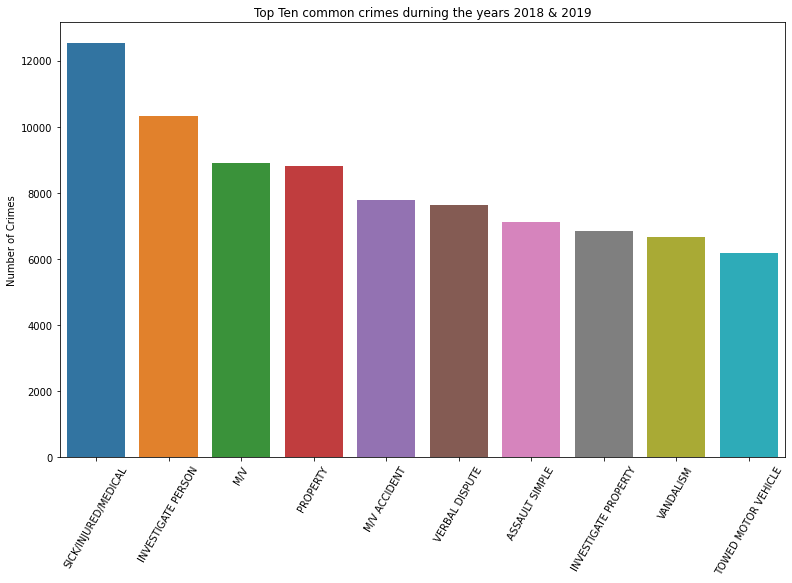

In [47]:
# plot the Top Ten common crimes during the years 2018,2019
# Set the width and height of the figure
plt.figure(figsize=(13,8))

# Add title
plt.title("Top Ten common crimes durning the years 2018 & 2019")

sns.barplot(x=top_10.index,y=top_10)

#Rotate x-labels, otherwise it's utterly hectic
plt.xticks(rotation=60)

# Add label for vertical axis
plt.ylabel("Number of Crimes");

In [48]:
#create a dataframe for only 2020, 2021 & 2022 years
df_2020_2022=norm.loc[norm.loc[:,'Year'].between(2020,2022)].copy()
df_2020_2022.head()

,INCIDENT_NUMBER,OFFENSE_CODE,Description,Group,UCR_PART,Street,DISTRICT_ID,DISTRICT_NAME,Lat,Long,REPORTING_AREA,SHOOTING,Date,Year,Month,Day,Hour
154983,854652314,3115,INVESTIGATE PERSON,INVESTIGATE PERSON,Part Three,ZELLER ST,E5,WEST ROXBURY,42.291866,-71.136355,289.0,0,2020-02-20 00:00:00,2020,2,Thursday,0
154984,457856954,3115,INVESTIGATE PERSON,INVESTIGATE PERSON,Part Three,ZELLER ST,E5,WEST ROXBURY,42.291866,-71.136355,289.0,0,2020-02-21 01:42:00,2020,2,Friday,1
154985,302030654,1106,FRAUD - CREDIT CARD / ATM FRAUD,FRAUD,Part Two,ZELLER ST,E5,WEST ROXBURY,42.291866,-71.136355,167.0,0,2020-04-24 13:00:00,2020,4,Friday,13
154986,212025777,1108,FRAUD - WELFARE,FRAUD,Part Two,ZELLER ST,E5,WEST ROXBURY,42.291866,-71.136355,28.0,0,2020-05-01 00:00:00,2020,5,Friday,0
154987,212025557,2670,CRIMINAL HARASSMENT,CRIMINAL HARASSMENT,Part Two,ZELLER ST,E5,WEST ROXBURY,42.291866,-71.136355,77.0,0,2020-09-07 00:00:00,2020,9,Monday,0


In [49]:
#using groupby(Year) to display the common crimes during the years 2020, 2021 and 2022, sorted in descending order
crime_years_post =df_2020_2022.groupby('Year')['Group']
crime_years_post.value_counts().sort_values(ascending=False).head(6)

Year  Group             
2021  INVESTIGATE PERSON    5104
2020  INVESTIGATE PERSON    4545
      FRAUD                 3768
2021  SICK ASSIST           3733
2020  SICK ASSIST           3722
2021  M/V                   3674
Name: Group, dtype: int64

In [50]:
#Top Ten crimes that happned over the years 2020, 2021 and 2022
#Check how many counts per unique value of Group

top_10_post=df_2020_2022['Group'].value_counts().sort_values(ascending=False).head(10)
top_10_post

INVESTIGATE PERSON      12261
M/V                      9055
ASSAULT                  8075
SICK ASSIST              7455
PROPERTY                 7083
FRAUD                    6960
M/V ACCIDENT             6862
VANDALISM                6399
INVESTIGATE PROPERTY     6362
SICK/INJURED/MEDICAL     5188
Name: Group, dtype: int64

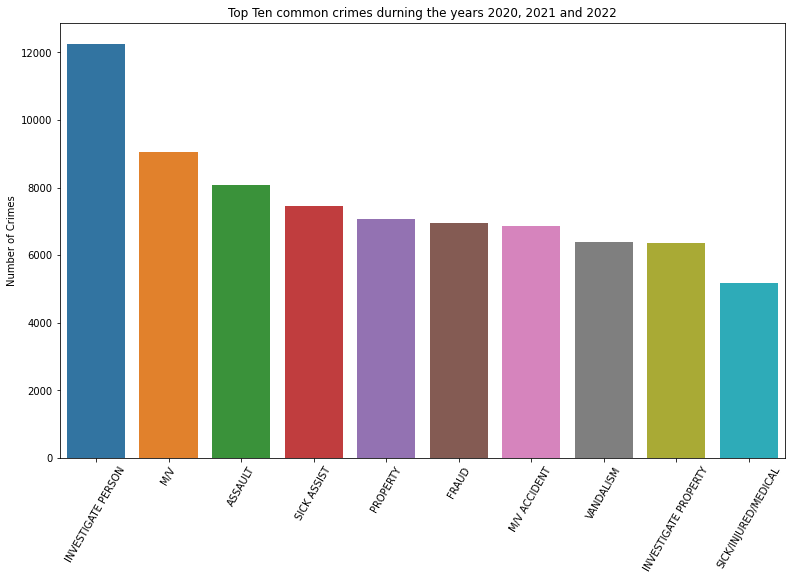

In [51]:
# plot the Top Ten common crimes during the years 2020, 2021 and 2022
# Set the width and height of the figure
plt.figure(figsize=(13,8))

# Add title
plt.title("Top Ten common crimes durning the years 2020, 2021 and 2022")

sns.barplot(x=top_10_post.index,y=top_10_post)

#Rotate x-labels, otherwise it's utterly hectic
plt.xticks(rotation=60)

# Add label for vertical axis
plt.ylabel("Number of Crimes");